In [1]:
#Get the data "CIFAR-10 dataset
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'
floyd_cifar10_location = '/input/cifar-10/python.tar.gz'
if isfile(floyd_cifar10_location):
    tar_gz_path = floyd_cifar10_location
else:
    tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 5:
Image - Min Value: 0 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


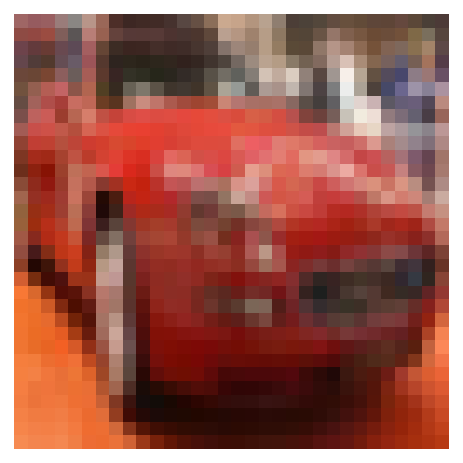

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pickle
import numpy as np
import matplotlib.pyplot as plt

def _load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels

def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    batch_ids = list(range(1, 6))

    if batch_id not in batch_ids:
        print('Batch Id out of Range. Possible Batch Ids: {}'.format(batch_ids))
        return None

    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch {}:'.format(batch_id))
    print('Samples: {}'.format(len(features)))
    print('Label Counts: {}'.format(dict(zip(*np.unique(labels, return_counts=True)))))
    print('First 20 Labels: {}'.format(labels[:20]))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    label_names = _load_label_names()

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    plt.axis('off')
    plt.imshow(sample_image)
    
# Explore the dataset
batch_id = 1
sample_id = 5
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

In [3]:
def normalize(x):
    return np.divide(x, np.max(x))

In [4]:
from sklearn import preprocessing

def one_hot_encode(x):
    lb = preprocessing.LabelBinarizer()
    lb.fit(x)
    lb.classes_=[0,1,2,3,4,5,6,7,8,9]
    return lb.transform(x).astype(np.float32)

In [5]:
# Preprocess Training, Validation, and Testing Data
def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))

def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        validation_count = int(len(features) * 0.1)

        _preprocess_and_save(
            normalize,
            one_hot_encode,
            features[:-validation_count],
            labels[:-validation_count],
            'preprocess_batch_' + str(batch_i) + '.p')

        # Use a portion of training batch for validation
        valid_features.extend(features[-validation_count:])
        valid_labels.extend(labels[-validation_count:])

    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(valid_features),
        np.array(valid_labels),
        'preprocess_validation.p')

    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(test_features),
        np.array(test_labels),
        'preprocess_test.p')

preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

In [6]:
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

In [7]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    return tf.placeholder(tf.float32, shape=[None, image_shape[0], image_shape[1], image_shape[2]], name="x")

def neural_net_label_input(n_classes):
    return tf.placeholder(tf.float32, shape=[None, n_classes], name="y")

def neural_net_keep_prob_input():
    return tf.placeholder(tf.float32, name="keep_prob")

C:\Users\parkj\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\parkj\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\parkj\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\parkj\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dty

In [8]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    w = tf.Variable(tf.truncated_normal((conv_ksize[0], conv_ksize[1], int(x_tensor.shape[3]), conv_num_outputs), 
                                        mean=0.0, 
                                        stddev=0.05,
                                        dtype=tf.float32,
                                        seed=None,
                                        name=None))
    b = tf.Variable(tf.zeros(conv_num_outputs))
    strides = [1, conv_strides[0], conv_strides[1], 1]
    padding = 'VALID'
    conv_layer = tf.nn.conv2d(x_tensor, w, strides, padding)
    conv_layer = tf.nn.bias_add(conv_layer, b)
    conv_layer = tf.nn.relu(conv_layer)
    
    return tf.nn.max_pool(conv_layer, [1,pool_ksize[0],pool_ksize[1],1], [1,pool_strides[0],pool_strides[1],1], padding)

In [9]:
def flatten(x_tensor):
    new = tf.reshape(x_tensor, [-1, int(x_tensor.shape[1])*int(x_tensor.shape[2])*int(x_tensor.shape[3])])
    return new

In [10]:
def fully_conn(x_tensor, num_outputs):
    w = tf.Variable(tf.truncated_normal([int(x_tensor.shape[1]), num_outputs],
                                        mean=0.0, stddev=0.05, dtype=tf.float32, seed=None, name=None))   
    b = tf.Variable(tf.zeros(num_outputs))
    fc = tf.reshape(x_tensor, [-1, w.get_shape().as_list()[0]])
    fc = tf.add(tf.matmul(fc, w), b)
    
    return tf.nn.relu(fc)

In [11]:
def output(x_tensor, num_outputs):
    w = tf.Variable(tf.truncated_normal([int(x_tensor.shape[1]), num_outputs],
                                       mean=0.0, stddev=0.05, dtype=tf.float32, seed=None, name=None))
    b = tf.Variable(tf.truncated_normal([num_outputs], mean=0.0, stddev=0.05, dtype=tf.float32, seed=None, name=None))
    
    return tf.add(tf.matmul(x_tensor, w), b)

In [12]:
def conv_net(x, keep_prob):
    conv1 = conv2d_maxpool(x, 16, (5, 5), (1, 1), (2, 2), (2, 2))
    conv2 = conv2d_maxpool(conv1, 32, (3,3), (1,1), (2,2), (2,2))
    conv3 = conv2d_maxpool(conv2, 64, (3,3), (1,1), (2,2), (2,2))
    
    conv = flatten(conv3)
    
    fc1 = fully_conn(conv, 256)
    fc1 = tf.nn.dropout(fc1, keep_prob)   
    fc2 = fully_conn(fc1, 128)
    out = output(fc2, 10)
    
    return out

# Neural Network build
tf.reset_default_graph()

x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)

keep_prob = neural_net_keep_prob_input()
logits = conv_net(x, keep_prob)
logits = tf.identity(logits, name='logits')
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [13]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    session.run(optimizer, feed_dict={x: feature_batch, y: label_batch, keep_prob: keep_probability})   

In [14]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    loss = sess.run(cost,
                    feed_dict={x: feature_batch,
                               y: label_batch,
                               keep_prob: 1.})
    valid_acc = session.run(accuracy, 
                            feed_dict={x: valid_features,
                                       y: valid_labels,
                                       keep_prob: 1.})

    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, valid_acc))

In [15]:
epochs = 50
batch_size = 512
keep_probability = .5

In [16]:
# Checking the Training on a Single Batch...
def batch_features_labels(features, labels, batch_size):
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

def load_preprocess_training_batch(batch_id, batch_size):
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))
    return batch_features_labels(features, labels, batch_size)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Epoch  1, CIFAR-10 Batch 1:  Loss:     2.2628 Validation Accuracy: 0.109200
Epoch  2, CIFAR-10 Batch 1:  Loss:     2.1341 Validation Accuracy: 0.211200
Epoch  3, CIFAR-10 Batch 1:  Loss:     2.0491 Validation Accuracy: 0.257800
Epoch  4, CIFAR-10 Batch 1:  Loss:     2.0124 Validation Accuracy: 0.266200
Epoch  5, CIFAR-10 Batch 1:  Loss:     1.9772 Validation Accuracy: 0.293800
Epoch  6, CIFAR-10 Batch 1:  Loss:     1.9198 Validation Accuracy: 0.298000
Epoch  7, CIFAR-10 Batch 1:  Loss:     1.9012 Validation Accuracy: 0.318000
Epoch  8, CIFAR-10 Batch 1:  Loss:     1.8606 Validation Accuracy: 0.334000
Epoch  9, CIFAR-10 Batch 1:  Loss:     1.7973 Validation Accuracy: 0.360400
Epoch 10, CIFAR-10 Batch 1:  Loss:     1.7704 Validation Accuracy: 0.365000
Epoch 11, CIFAR-10 Batch 1:  Loss:     1.7320 Validation Accuracy: 0.377800
Epoch 12, CIFAR-10 Batch 1:  Loss:     1.6645 Validation Accuracy: 0.405600
Epoch 13, CIFAR-10 Batch 1:  Loss:     1.6541 Validation Accuracy: 0.406800
Epoch 14, CI

In [17]:
save_model_path = './image_classification'

#Training...
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())    
    for epoch in range(epochs):
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Epoch  1, CIFAR-10 Batch 1:  Loss:     2.2047 Validation Accuracy: 0.209800
Epoch  1, CIFAR-10 Batch 2:  Loss:     2.0730 Validation Accuracy: 0.190800
Epoch  1, CIFAR-10 Batch 3:  Loss:     1.9737 Validation Accuracy: 0.231600
Epoch  1, CIFAR-10 Batch 4:  Loss:     1.9391 Validation Accuracy: 0.241200
Epoch  1, CIFAR-10 Batch 5:  Loss:     1.9176 Validation Accuracy: 0.281800
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.9539 Validation Accuracy: 0.290800
Epoch  2, CIFAR-10 Batch 2:  Loss:     1.8041 Validation Accuracy: 0.322400
Epoch  2, CIFAR-10 Batch 3:  Loss:     1.6272 Validation Accuracy: 0.338600
Epoch  2, CIFAR-10 Batch 4:  Loss:     1.6729 Validation Accuracy: 0.358800
Epoch  2, CIFAR-10 Batch 5:  Loss:     1.7051 Validation Accuracy: 0.373200
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.8174 Validation Accuracy: 0.353200
Epoch  3, CIFAR-10 Batch 2:  Loss:     1.6839 Validation Accuracy: 0.396200
Epoch  3, CIFAR-10 Batch 3:  Loss:     1.4264 Validation Accuracy: 0.405400
Epoch  3, CI

Epoch 22, CIFAR-10 Batch 4:  Loss:     0.7690 Validation Accuracy: 0.617200
Epoch 22, CIFAR-10 Batch 5:  Loss:     0.8309 Validation Accuracy: 0.625800
Epoch 23, CIFAR-10 Batch 1:  Loss:     0.9413 Validation Accuracy: 0.621000
Epoch 23, CIFAR-10 Batch 2:  Loss:     0.8628 Validation Accuracy: 0.623800
Epoch 23, CIFAR-10 Batch 3:  Loss:     0.7618 Validation Accuracy: 0.622200
Epoch 23, CIFAR-10 Batch 4:  Loss:     0.7400 Validation Accuracy: 0.624400
Epoch 23, CIFAR-10 Batch 5:  Loss:     0.8153 Validation Accuracy: 0.631800
Epoch 24, CIFAR-10 Batch 1:  Loss:     0.9282 Validation Accuracy: 0.623400
Epoch 24, CIFAR-10 Batch 2:  Loss:     0.8661 Validation Accuracy: 0.623000
Epoch 24, CIFAR-10 Batch 3:  Loss:     0.7590 Validation Accuracy: 0.617400
Epoch 24, CIFAR-10 Batch 4:  Loss:     0.7339 Validation Accuracy: 0.629200
Epoch 24, CIFAR-10 Batch 5:  Loss:     0.8044 Validation Accuracy: 0.635600
Epoch 25, CIFAR-10 Batch 1:  Loss:     0.9198 Validation Accuracy: 0.633200
Epoch 25, CI

Epoch 44, CIFAR-10 Batch 2:  Loss:     0.5681 Validation Accuracy: 0.669600
Epoch 44, CIFAR-10 Batch 3:  Loss:     0.5187 Validation Accuracy: 0.672000
Epoch 44, CIFAR-10 Batch 4:  Loss:     0.5512 Validation Accuracy: 0.651400
Epoch 44, CIFAR-10 Batch 5:  Loss:     0.6108 Validation Accuracy: 0.663800
Epoch 45, CIFAR-10 Batch 1:  Loss:     0.6288 Validation Accuracy: 0.661600
Epoch 45, CIFAR-10 Batch 2:  Loss:     0.6141 Validation Accuracy: 0.660400
Epoch 45, CIFAR-10 Batch 3:  Loss:     0.5412 Validation Accuracy: 0.670600
Epoch 45, CIFAR-10 Batch 4:  Loss:     0.5023 Validation Accuracy: 0.666200
Epoch 45, CIFAR-10 Batch 5:  Loss:     0.5907 Validation Accuracy: 0.668200
Epoch 46, CIFAR-10 Batch 1:  Loss:     0.6472 Validation Accuracy: 0.652600
Epoch 46, CIFAR-10 Batch 2:  Loss:     0.5676 Validation Accuracy: 0.673800
Epoch 46, CIFAR-10 Batch 3:  Loss:     0.5122 Validation Accuracy: 0.671400
Epoch 46, CIFAR-10 Batch 4:  Loss:     0.5106 Validation Accuracy: 0.668600
Epoch 46, CI

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.6701631426811219



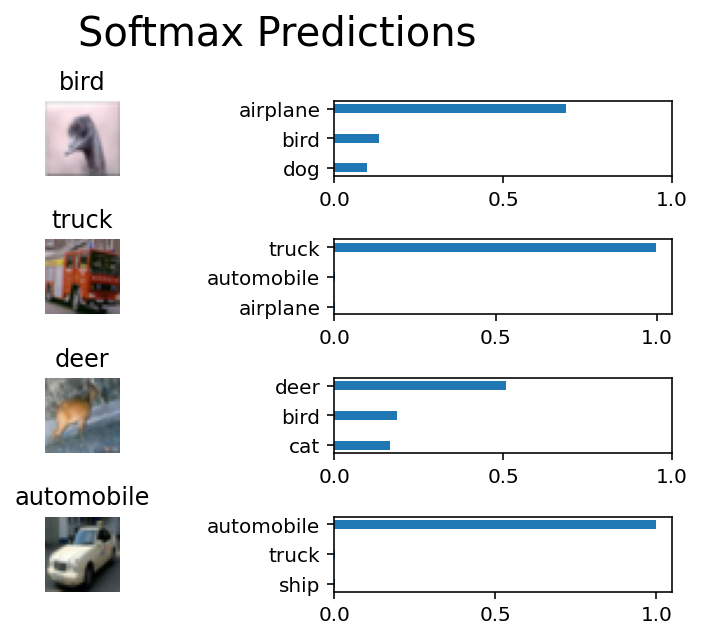

In [18]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import random
from sklearn.preprocessing import LabelBinarizer

try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = _load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=4, ncols=2)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]

        axies[image_i][0].imshow(feature)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])

def test_model():
    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()